In [40]:
#using Pkg
#Pkg.add("Interpolations")
#Pkg.add("Dierckx")
#Pkg.add("Gadfly")
b = `ls`
run(b)

Chop_bursts.ipynb
DEM_to_sali.ipynb
Fake_point.ipynb
Function test.ipynb
Get meta info_burst.ipynb
Load and fit POD test.ipynb
POD_path.txt
ann_path.txt
calc_sat_trajectory.jl
convert_time.jl
ellipsoid2xyz.jl
full_test.ipynb
interpolate_dem.ipynb
llh2sali.jl
load_pod.jl
load_s1slc_ann.jl
open_DEM.ipynb
reproject_dem.jl
test zero_doppler_bisect.ipynb
zero_doppler_bisect.jl


Process(`ls`, ProcessExited(0))

### SYNTHETIC TEST - Getting to know Dierckx (interpolation)

In [1]:
using Dierckx
using Plots
using PyCall
using Images
using Statistics

┌ Info: Recompiling stale cache file /Users/eyu/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/eyu/.julia/compiled/v1.1/Images/H8Vxc.ji for Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1184


In [2]:
scipy_interp = pyimport("scipy.interpolate");

In [240]:
# random function and random (x,y) positions (sorted)
f(x,y) = log(x+y)
x = (rand(1.:.1:10., 1000)) #rand(5);
y = (rand(1.:.1:10., 1000)) #rand(5);
xy = hcat(x, y)
# choose z value
z = [f(xi, yi) for (xi, yi) in zip(x, y)];
#z = [f(xi, xi) for xi=1:length(x)];

# create grid to evaluate interpolation to
grid_size = 10
y_tmp = [convert(Int, i) for i in collect(1:10)]
x_tmp = y_tmp
y_grid = Array{Int}(undef, 10, 0)
for i in 1:grid_size
    y_grid = hcat(y_grid, y_tmp)
end
x_grid = y_grid';

In [69]:
grid_z1 = scipy_interp.griddata(xy, z, (x_grid, y_grid), method="linear")


10×10 Array{Float64,2}:
 NaN          1.09686    1.38127  1.60864  …  2.1971   2.29809    2.3979 
   1.09701    1.38629    1.60926  1.79176     2.30246  2.39777    2.48308
   1.38299    1.60746    1.79176  1.94591     2.39775  2.48488    2.5614 
   1.60635    1.79135    1.94591  2.07772     2.48475  2.56487    2.63901
   1.77977    1.94334    2.07924  2.1971      2.56477  2.63884    2.70798
   1.93985    2.07944    2.1966   2.30259  …  2.63899  2.70769    2.77257
   2.07574    2.19633    2.30246  2.39761     2.70793  2.77257    2.83251
   2.19662    2.30251    2.39765  2.48491     2.77259  2.83319    2.88961
   2.30039    2.3979     2.48409  2.5649      2.8332   2.89034    2.94444
 NaN        NaN        NaN        2.63798     2.89025  2.94433  NaN      

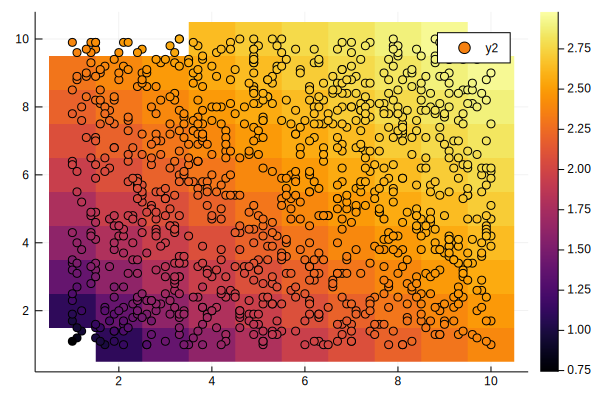

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not refelct all series correctly.
└ @ Plots /Users/eyu/.julia/packages/Plots/Ih71u/src/backends/gr.jl:483


In [70]:
heatmap(grid_z1)
scatter!(x, y, marker_z=z)

### REAL DATA - Interpolate small subset

In [71]:
rasterio = pyimport("rasterio");
file = open("dem_path.txt")
filename = readlines(file)[1]
dataset = rasterio.open(filename);

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [72]:
DEM = dataset.read(1);

In [73]:
transform = dataset.get_transform()

6-element Array{Float64,1}:
  5.0                  
  0.0008333333333333334
  0.0                  
 60.0                  
  0.0                  
 -0.0008333333333333334

### Calc Lat long for DEM

In [74]:
rows = collect(1:dataset.height);
columns = collect(1:dataset.width);
lon = transform[1] .+rows .*transform[2];
lat  = transform[4] .+columns .*transform[6];

### Crop DEM to coords
found some place in annotation

In [75]:
# crop around corner reflector
lat_center = (56 + 33/60 + 42.5556/(60*60))
lon_center = (8 + 18/60 + 26.874/(60*60))

lat_max = lat_center + 0.02 # 5.666818777336966e+01
lon_max = lon_center + 0.06 # 8.692126035601964e+00;
lat_min = lat_center - 0.02 # 5.514243624845066e+01
lon_min = lon_center - 0.06# 6.863612098279713e+00;

In [76]:
index1 = lat_min .<lat.< lat_max;
index2 = lon_min .<lon.< lon_max;

In [77]:
test = DEM[index1,index2];
lat = lat[index1]
lon = lon[index2];

In [78]:
### TO elipsoidal 

test = test .+ 39;

### Remove NaN values

In [79]:
test[test .== (-32768+ 39)] .= 10;

### Show DEM

In [80]:
Show_img = abs.(copy(test))
Show_img = Show_img./quantile(reshape(Show_img, :), 0.98);

┌ Info: Recompiling stale cache file /Users/eyu/.julia/compiled/v1.1/QuartzImageIO/n8vDP.ji for QuartzImageIO [dca85d43-d64c-5e67-8c65-017450d5d020]
└ @ Base loading.jl:1184


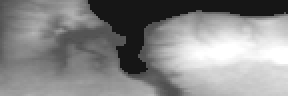

In [81]:
Gray.(Show_img)

### Create 2d array with points

In [82]:
lat_matrix = Array{Float64}(undef, length(lat), length(lon))
lon_matrix = Array{Float64}(undef,length(lat), length(lon))

for i = 1:length(lat)
    for j = 1:length(lon)
        lat_matrix[i,j] = lat[i]
        lon_matrix[i,j] = lon[j]
    end
end   

In [83]:
llh = hcat(reshape(lat_matrix,:),reshape(lon_matrix,:),reshape(test,:));

### Transform to sat coordinates

In [84]:
include("llh2sali.jl")
include("load_pod.jl")
include("load_s1slc_ann.jl");

In [85]:
file = open("ann_path.txt")
path = readlines(file)
sar_parameters = load_s1slc_ann(path[1])

file = open("POD_path.txt")
path = readlines(file)
osv, t_sv = load_pod(path[1],sar_parameters["t_0"]);

In [86]:
sali = llh2sali(llh, osv, t_sv, sar_parameters);

### Interpolate

In [87]:
sali_subset = sali;
z = reshape(test,:);

In [88]:
pyplot()

Plots.PyPlotBackend()

In [89]:
z[60 .<z] .= 60 ;

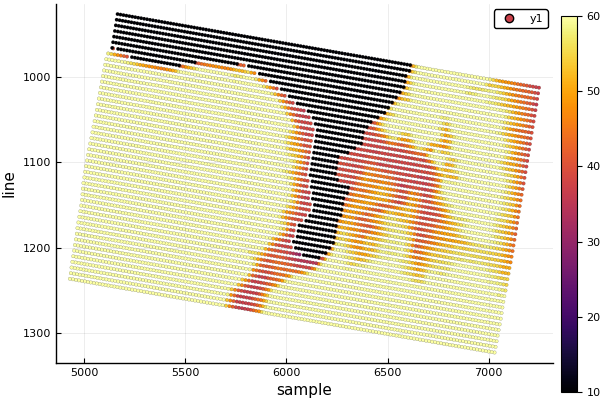

In [90]:
steps= 1
scatter(sali_subset[1:steps:end,2],sali_subset[1:steps:end,1],
    zcolor=z[1:steps:end],
    yaxis = ("line", :flip),xaxis = ("sample"),
    markersize=2.5, markerstrokewidth = 0.1)

In [204]:
steps= 1
x = sali_subset[1:steps:end,2]
y = sali_subset[1:steps:end,1]
xy = hcat(x, y)
z_ = z[1:steps:end];
z_ = [convert(Float64, i) for i in z_];

In [236]:
# create grid to evaluate interpolation to
x_tmp = [convert(Int, i) for i in collect(5300:7000)]
y_tmp = [convert(Int, i) for i in collect(1000:1220)]

y_grid = Array{Int}(undef, length(y_tmp), 0)
x_grid = Array{Int}(undef, length(x_tmp), 0)

for i in 1:length(x_tmp)
    y_grid = hcat(y_grid, y_tmp)
end

for i in 1:length(y_tmp)
    x_grid = hcat(x_grid, x_tmp)
end
x_grid = x_grid';

In [237]:
x_grid[1:4, 1:10]

4×10 Array{Int64,2}:
 5300  5301  5302  5303  5304  5305  5306  5307  5308  5309
 5300  5301  5302  5303  5304  5305  5306  5307  5308  5309
 5300  5301  5302  5303  5304  5305  5306  5307  5308  5309
 5300  5301  5302  5303  5304  5305  5306  5307  5308  5309

In [238]:
grid_z = scipy_interp.griddata(xy, z_, (x_grid, y_grid), method="linear")

#eval_spline = evalgrid(spline, grid_x, grid_y);

In [211]:
z_grid[1:5, 1:5]

5×5 Array{Float64,2}:
 59.5083  59.5121  59.5162  59.5205  59.5251
 60.1939  60.1899  60.1858  60.1817  60.1776
 60.6113  60.6036  60.5957  60.5876  60.5793
 60.749   60.7418  60.7343  60.7265  60.7185
 60.6776  60.6737  60.6696  60.6652  60.6606

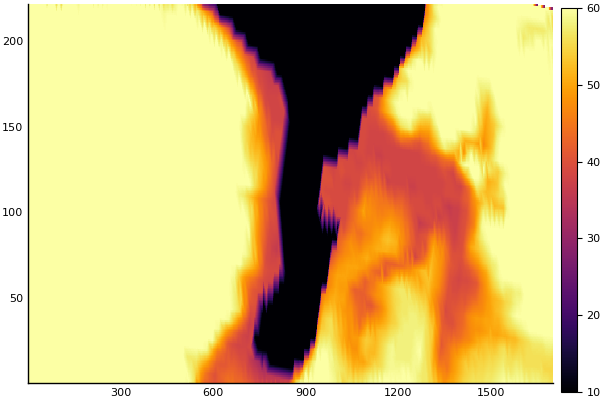

In [239]:
# note x-axis and y-axis are off
heatmap(grid_z[end:-1:1, :])

#### Comments: 

Note that the heatmap above is zoomed in, and that axis are off. Seems to be the best I can get with current knowledge of package. It is a trade-off between (kx,ky) order and s value, the larger the smoother - but cannot be decreased much more (function won't run if s<2300, unless there is less points or (kx,ky) is decreased). Maybe experiment with even smaller subset of data.

### RODEBUTIK


In [9]:
# random function and random (x,y) positions (sorted)
f(x,y) = log(x+y)
x = (rand(1.:.1:10., 1000)) #rand(5);
y = (rand(1.:.1:10., 1000)) #rand(5);

# choose z value
z = [f(xi, yi) for (xi, yi) in zip(x, y)];
#z = [f(xi, xi) for xi=1:length(x)];

In [42]:
# Spline2D takes: (3 lists) or (x-coords, y-coords, z:2d array). 
# kx, ky is spline order, 
# s is some error target for smoothing splines at knot points, smaller is harder but better
@time spline = Spline2D(x, y, z, kx=2, ky=2, s=100)

# create grid to evaluate interpolation to
xs = collect(1.:10.)
ys = collect(1.:10.)

# evaluate spline
@time eval_spline = evalgrid(spline, xs, ys) # xs og ys skal være koordinater

  0.001012 seconds (20 allocations: 863.078 KiB)
  0.000011 seconds (7 allocations: 1.750 KiB)


10×10 Array{Float64,2}:
 0.878065  1.14899  1.39342  1.61138  …  2.10634  2.21836  2.3039   2.36296
 1.14754   1.37838  1.58782  1.77586     2.21158  2.31402  2.39506  2.4547 
 1.39101   1.58676  1.76552  1.92728     2.31057  2.40434  2.48111  2.54088
 1.60846   1.77413  1.92653  2.06564     2.40333  2.48933  2.56206  2.6215 
 1.79989   1.94048  2.07084  2.19095     2.48984  2.56899  2.6379   2.69657
 1.96531   2.08582  2.19845  2.3032   …  2.57012  2.64333  2.70865  2.76608
 2.10471   2.21015  2.30937  2.40239     2.64416  2.71233  2.77429  2.83003
 2.2181    2.31346  2.4036   2.48852     2.71196  2.776    2.83482  2.88843
 2.30547   2.39575  2.48113  2.56159     2.77352  2.83434  2.89026  2.94126
 2.36683   2.45704  2.54196  2.6216      2.82884  2.88735  2.94059  2.98854

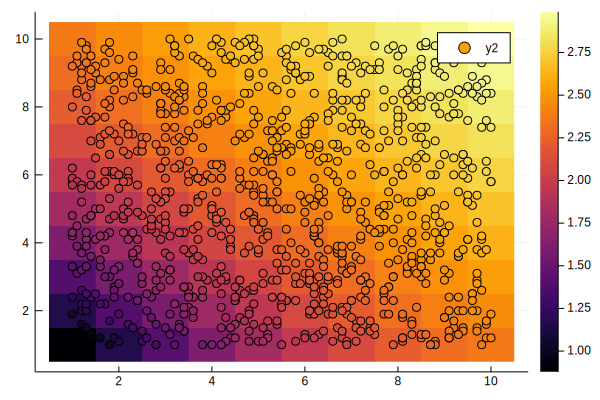

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not refelct all series correctly.
└ @ Plots /Users/eyu/.julia/packages/Plots/Ih71u/src/backends/gr.jl:483


In [41]:
# reshape interpolated values for plotting
#plot_spline = reshape(eval_spline, (10,10))

# plot interpolated grid and original values:
heatmap(eval_spline)
scatter!(x,y, marker_z=z)